In [ ]:
!pip install 'git+https://github.com/salesforce/LAVIS.git'

In [1]:
import torch

from PIL import Image
from lavis.models import load_model_and_preprocess

[1690878873.307132] [sfr-pod-li-d-a100x16-2306-2:7657 :f]        vfs_fuse.c:281  UCX  ERROR inotify_add_watch(/tmp) failed: No space left on device


/usr/local/lib/python3.10/dist-packages/diffusers/models/cross_attention.py:30: FutureWarning: Importing from cross_attention is deprecated. Please import from diffusers.models.attention_processor instead.
  deprecate(


In [2]:
torch.cuda.is_available()

True

In [3]:
model, vis_preprocess, txt_preprocess = load_model_and_preprocess("blip_diffusion", "base", device="cuda", is_eval=True)

Some weights of BertLMHeadModel were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['bert.encoder.layer.6.crossattention.output.LayerNorm.bias', 'bert.encoder.layer.6.output_query.LayerNorm.bias', 'bert.encoder.layer.10.crossattention.self.value.weight', 'bert.encoder.layer.5.output_query.dense.bias', 'bert.encoder.layer.2.crossattention.output.LayerNorm.weight', 'bert.encoder.layer.7.intermediate_query.dense.bias', 'bert.encoder.layer.5.crossattention.self.query.weight', 'bert.encoder.layer.10.crossattention.output.dense.weight', 'bert.encoder.layer.9.intermediate_query.dense.bias', 'bert.encoder.layer.7.crossattention.output.dense.bias', 'bert.encoder.layer.10.crossattention.output.LayerNorm.bias', 'bert.encoder.layer.1.crossattention.self.query.weight', 'bert.encoder.layer.9.crossattention.self.query.weight', 'bert.encoder.layer.0.output_query.LayerNorm.weight', 'bert.encoder.layer.3.intermediate_query.dense.weight', 'bert.encoder.layer.9.

Cannot initialize model with low cpu memory usage because `accelerate` was not found in the environment. Defaulting to `low_cpu_mem_usage=False`. It is strongly recommended to install `accelerate` for faster and less memory-intense model loading. You can do so with: 
```
pip install accelerate
```
.
Cannot initialize model with low cpu memory usage because `accelerate` was not found in the environment. Defaulting to `low_cpu_mem_usage=False`. It is strongly recommended to install `accelerate` for faster and less memory-intense model loading. You can do so with: 
```
pip install accelerate
```
.
/usr/local/lib/python3.10/dist-packages/diffusers/configuration_utils.py:217: FutureWarning: It is deprecated to pass a pretrained model name or path to `from_config`.If you were trying to load a scheduler, please use <class 'diffusers.schedulers.scheduling_ddpm.DDPMScheduler'>.from_pretrained(...) instead. Otherwise, please make sure to pass a configuration dictionary instead. This functionalit

No ctx_embeddings_cache found in /root/.cache/torch/hub/checkpoints/blip-diffusion


### Description
This demo shows how to edit an image with a given subject as condition. It works in the following steps:

(1) generating a synthetic image, using the prompt ``A ${src_subject} ${prompt}.``;

(2) extracting BLIP-2 embeddings on condition subject image, using ``cond_subject`` and ``cond_image``.

(3) edit the synthetic image with the subject visuals, using the prompt ``A ${BLIP-2 embedding} ${tgt_subject} ${prompt}``.

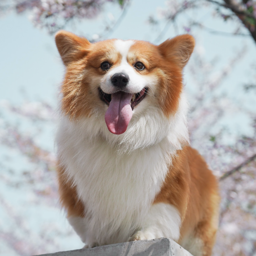

In [4]:
cond_subject = "dog"
src_subject = "cat"
tgt_subject = "dog"

text_prompt = "sit on a chair, oil painting"

cond_subject = txt_preprocess["eval"](cond_subject)
src_subject = txt_preprocess["eval"](src_subject)
tgt_subject = txt_preprocess["eval"](tgt_subject)
text_prompt = [txt_preprocess["eval"](text_prompt)]

cond_image = Image.open("../images/dog.png").convert("RGB")
display(cond_image.resize((256, 256)))

cond_image = vis_preprocess["eval"](cond_image).unsqueeze(0).cuda()


In [5]:
samples = {
    "cond_images": cond_image,
    "cond_subject": cond_subject,
    "src_subject": src_subject,
    "tgt_subject": tgt_subject,
    "prompt": text_prompt,
}

['a cat sit on a chair, oil painting', 'a sks sks sks sks sks sks sks sks sks sks sks sks sks sks sks sks dog sit on a chair, oil painting']


/export/home/workspace/LAVIS-latest/LAVIS/lavis/models/blip_diffusion_models/blip_diffusion.py:325: FutureWarning: Accessing config attribute `in_channels` directly via 'UNet2DConditionModel' object attribute is deprecated. Please access 'in_channels' over 'UNet2DConditionModel's config object instead, e.g. 'unet.config.in_channels'.
  (1, self.unet.in_channels, height // 8, width // 8),
/export/home/workspace/LAVIS-latest/LAVIS/lavis/models/blip_diffusion_models/blip_diffusion.py:331: FutureWarning: Accessing config attribute `in_channels` directly via 'UNet2DConditionModel' object attribute is deprecated. Please access 'in_channels' over 'UNet2DConditionModel's config object instead, e.g. 'unet.config.in_channels'.
  self.unet.in_channels,
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 51/51 [00:05<00:00, 10.14it/s]


Before editing:


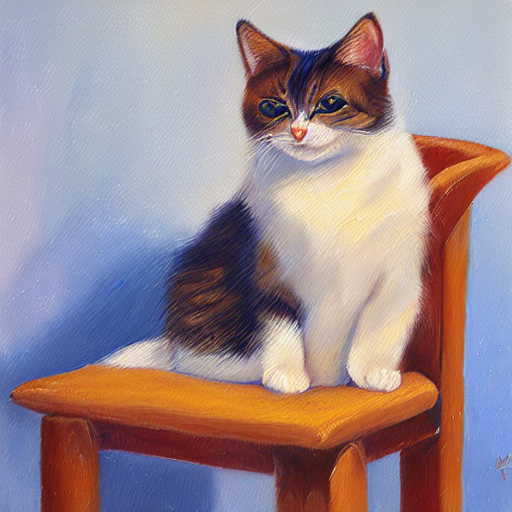

After editing:


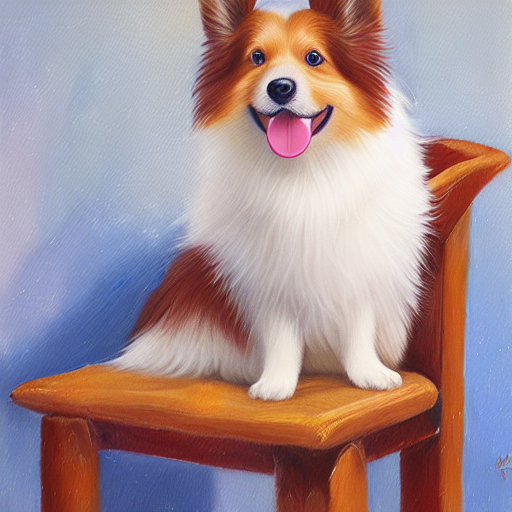

In [6]:
iter_seed = 88991
guidance_scale = 7.5
num_inference_steps = 50
negative_prompt = "over-exposure, under-exposure, saturated, duplicate, out of frame, lowres, cropped, worst quality, low quality, jpeg artifacts, morbid, mutilated, out of frame, ugly, bad anatomy, bad proportions, deformed, blurry, duplicate"

output = model.generate_then_edit(
    samples,
    seed=iter_seed,
    guidance_scale=guidance_scale,
    num_inference_steps=num_inference_steps,
    neg_prompt=negative_prompt,
)

print("=" * 30)
print("Before editing:")
display(output[0])

print("After editing:")
display(output[1])